(pallas_tpu_pipelining)=

# TPU Pipelining

<!--* freshness: { reviewed: '2024-04-08' } *-->

This guide serves as a reference for TPU-specific pipelining concerns.
We'll review the memory hierarchy and compute units on TPUs, and TPU-specific features of the pipelining API. For a more general-purpose overview of pipelining, see the {ref}`pallas_software_pipelining`.

In [2]:
#@title Imports

import jax
from jax.experimental import pallas as pl
from jax.experimental.pallas import tpu as pltpu
import jax.numpy as jnp
import numpy as np

(tpu_and_its_memory_spaces)=

## TPU and its memory spaces

A TPU and its TensorCore consist of memory spaces (where arrays can reside),
registers (which temporarily store scalar and array values) and compute units
(that do computation with values in registers).
Below is a diagram of a TPU in which `x` and `y` are arrays that live in
high-bandwidth memory (HBM):

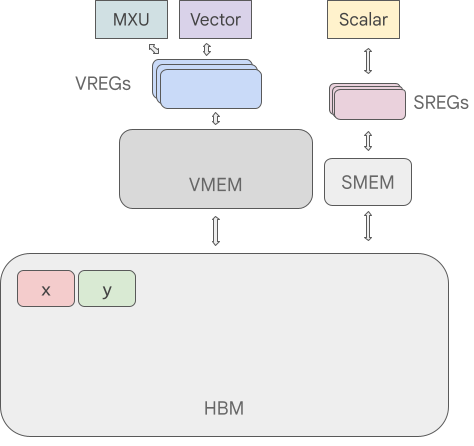

Let's talk about the components of this diagram in more detail:

* **Memory spaces**: A TPU has high-bandwidth memory (HBM) which is what we
  often think of as "device memory".
  There is also vector memory (VMEM),
  a cache meant for storing vector and array values, and scalar memory (SMEM),
  a cache designed to store scalar values.
* **Registers**: A TensorCore has two main types of registers: vector
  registers (VREGs) store array values, and scalar registers (SREGs) store
  scalar values.
  Values can be loaded into memory from their respective caches (VMEM for
  VREGs and SMEM for SREGs).
* **Compute units**: A TensorCore has a scalar unit, vector unit (VPU) and
  matrix unit (MXU) that can do numerical computation. Each of these compute units can operate asynchronously, but this is managed by the TPU compiler and thus from the programmer's perspective a TPU program is single-threaded.
  Compute units operate on values that live in SREGs and VREGs and output
  values into those registers as well.

## TPU-specific Pipelining Features

Pallas TPU supports the following platform-specific features.

### TPU Memory Spaces

Pallas exposes all levels of the TPU memory hierarchy to users. The following table maps from Pallas TPU memory spaces to their standard memory types (DRAM/SRAM):

| Pallas Enum | TPU Memory Space | Type (DRAM/SRAM) |
| --- | --- | --- |
| `pltpu.MemorySpace.ANY` | HBM (usually) or VMEM | DRAM |
| `pltpu.MemorySpace.VMEM` | VMEM | SRAM |
| `pltpu.MemorySpace.SMEM` | SMEM | SRAM |
| `pltpu.MemorySpace.SEMAPHORE` | Semaphore | SRAM |

- `MemorySpace.VMEM` denotes vector SRAM. It is the default memory space if nothing is specified.
- `MemorySpace.SMEM` denotes scalar SRAM. Only scalar loads and stores can be performed to/from SMEM.
- `MemorySpace.ANY` is a hint to the compiler that the memory space is unconstrained. In most cases, XLA will place this buffer in HBM. A buffer assigned to the `ANY` memory space cannot be dereferenced normally using array indexing syntax (e.g. `x[...]`). Instead, we must first copy the values into a VMEM or SMEM buffer using `pltpu.sync_copy` or `pltpu.async_copy`.
- `MemorySpace.SEMAPHORE` is used to allocate semaphores for constructing barriers or tracking asynchronous operations. It is also possible to return semaphores from the kernel for building asynchronous kernels - this is an experimental feature; see {ref}`pallas_async` for more details.

Pipelining on TPUs is typically done between HBM (DRAM) to VMEM (Vector SRAM). The default behavior for `pallas_call` on TPU is that arguments to `pallas_call` are assumed to live in HBM, and inputs to the user kernel body are stored in VMEM.

While not specific to pipelining, it is possible to gain manual control over the memory space of input and output buffers, you can specify the `memory_space` argument on a `BlockSpec`. Note that pipelining is not allowed unless the `memory_space` is marked as `VMEM`. Memory spaces can also be used to specify scratch arguments to a kernel via the `scratch_shapes` argument on `pallas_call`. Scratch buffers are persistent across kernel iterations and are useful for storing intermediate results such as partial accumulations and reductions. A scratch buffer must reside in `VMEM`, `SMEM`, or `SEMAPHORE`.

As an example for using multiple manual memory space assignments in a kernel, the following program copies a slice of an HBM buffer `x_hbm_ref` into a scratch VMEM buffer `scratch_vmem_ref` before using it for arithmetic and storing the result into an output VMEM buffer:

In [8]:
def hbm_vmem_kernel(x_hbm_ref, out_vmem_ref, scratch_vmem_ref):
  pltpu.sync_copy(x_hbm_ref.at[0:1], scratch_vmem_ref)
  out_vmem_ref[...] = scratch_vmem_ref[...] + 1

x = jax.random.uniform(jax.random.key(0), (8, 128), jnp.float32)
out = pl.pallas_call(hbm_vmem_kernel,
  in_specs=[pl.BlockSpec(memory_space=pltpu.MemorySpace.ANY)],
  out_shape=jax.ShapeDtypeStruct((1, 128), jnp.float32),
  scratch_shapes=(pltpu.MemorySpace.VMEM(shape=(1, 128), dtype=jnp.float32),)
)(x)

np.testing.assert_allclose(out, x[0:1] + 1)

(pallas_tpu_megacore)=

### TPUs in Megacore configuration

Some TPU chips have two TensorCores but appear as one device to JAX users.
This is called "megacore".
The separate TensorCores have their own separate VMEM, VREGs, SMEM, SREGs
and compute units but *share HBM*.

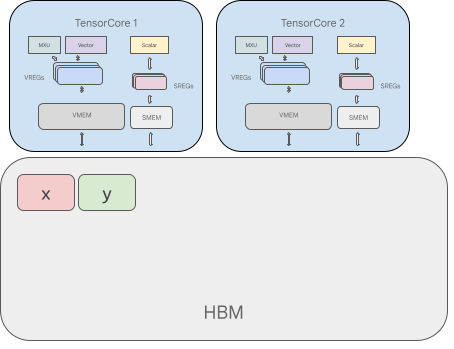

Conceptually, TPUs in Megacore behave like very simple GPUs, i.e. they have
only two threads.
How do we modify our kernels to utilize both TensorCores simultaneously?

The basic idea is that if we have embarrassingly parallel dimensions in our
computation, we can split up those dimensions across the TensorCores.
We can indicate which dimensions are parallelizable by providing an
annotation to `pallas_call` called `dimension_semantics`.

In [10]:
def add_matrices_kernel(x_vmem_ref, y_vmem_ref, z_vmem_ref):
  # Load x and y from VMEM into VREGs
  x_vregs = x_vmem_ref[:, :]
  y_vregs = y_vmem_ref[:, :]
  # Execute a vectorized add
  z_vregs = x_vregs + y_vregs
  # Store the output values in VREGs back into VMEM
  z_vmem_ref[:, :] = z_vregs

def add_matrices_pipelined_megacore(x: jax.Array, y: jax.Array) -> jax.Array:
  block_spec = pl.BlockSpec((256, 512), lambda i: (i, 0))
  return pl.pallas_call(
      add_matrices_kernel,
      out_shape=x,
      in_specs=[block_spec, block_spec],
      out_specs=block_spec,
      grid=(2,),
      compiler_params=pltpu.CompilerParams(
          dimension_semantics=("parallel",))
  )(x, y)

x, y = jnp.ones((512, 512)), jnp.ones((512, 512))
add_matrices_pipelined_megacore(x, y)

Array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]], dtype=float32)

`dimension_semantics` should be a tuple of same length as `grid` where each
entry is either `"parallel"` or `"arbitrary"`. `"parallel"` indicates to Pallas that the iterations of the for loop corresponding to that dimension can be executed independently without affecting the correctness of the program. `"arbitrary"` indicates to Pallas that there can be no assumptions made about this grid dimension and it therefore cannot be parallelized.

By specifying `dimension_semantics`, we now execute the kernel
simultaneously on each TensorCore. Pallas will handle splitting up the grid
automatically.

> Note that Megacore is only currently available on TPU `v4` and TPU `v5p`. Supplying `dimension_semantics` annotations is a no-op on other platforms, but *not* specifying it will result in only one TensorCore being used (even if there are more than one available).